# Code to make Figure 7
- Attribution of decadal differences based off DuVivier and Cassano 2016 method (doi: 10.1007/s00382-015-2697-8)
- Notebook by Alice DuVivier (NCAR)
- June 2023

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import dask
import utils
from scipy.stats import linregress,pearsonr, t, ttest_ind
import cmocean
import pickle
import geopandas as gpd

### Set User-specified information

In [2]:
# set paired values for possible winning maps based on Sammon maps
vars_in          = ['aice_d']  # training dataset
som_grid_rows    = [3]    # (y-axis)
som_grid_cols    = [3]    # (x-axis)
sigs             = [1.0]
lrs              = [0.005]
nitrs            = [100000]
ranks            = [9]

In [3]:
# MANUAL CHANGING REQUIRED HERE
n = 0
var_in = vars_in[n]
som_row = som_grid_rows[n]
som_col = som_grid_cols[n]
sig = sigs[n]
lr = lrs[n]
n_iter = nitrs[n]
rank = ranks[n]

In [4]:
# set the location of the already extracted training data
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v5/'
path_out = path_in+'figure_code/final_figures/'
# set shape files info
fname= '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v4/USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp' 

In [5]:
# set region of interest - for plotting
titles     = ['Ross Sea', 'Amundsen Bellingshausen Sea', 'Weddell Sea', 'Pacific Ocean', 'Indian Ocean']
shorts     = ['Ross', 'AMB', 'Wed', 'Pac', 'Ind']
masks      = ['Ross_mask', 'BAm_mask', 'Wed_mask', 'Pac_mask', 'Ind_mask']
lat_maxes  = [-72, -65, -65, -60, -60] 
lat_mins   = [-80, -85, -85, -80, -80]
lon_maxes  = [200, 300, 300, 90, 160] 
lon_mins   = [160, 220, 20, 20, 90]
lon_avgs   = [190, 260, 340, 55, 125]

In [7]:
# Based on sector set at top of script, set plotting limits
ind = shorts.index('Ross')
sector_title = titles[ind]
mask_in = masks[ind]
lat_max = lat_maxes[ind]
lat_min = lat_mins[ind]
lon_max = lon_maxes[ind]
lon_min = lon_mins[ind]
lon_avg = lon_avgs[ind]

### Load training data to interpret SOM

In [8]:
# construct the input name from this, set as output for figure names
fin = 'som_Ross_'+var_in+'_'+str(som_row)+'x'+str(som_col)+'_rank_'+str(rank)+'_sig'+str(sig)+'_lr'+str(lr)+'_iter'+str(n_iter)
print(fin)

som_Ross_aice_d_3x3_rank_9_sig1.0_lr0.005_iter100000


In [9]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [10]:
# open file saved in earlier notebook (soms_antarctica-gettingdata.ipynb)
subset = xr.open_dataset(path_in+'training_data_region_Ross_'+var_in+'.nc')

# assign to numpy array object
subsetarray = subset['train_data'].values

# set data
data = normalize_data(subsetarray)

# set data input length
input_length = subsetarray.shape[1]    # using preprocessed data array; Number of the elements of the vectors in input.


### Load Pickle with winning combos

In [11]:
# open pickle
with open(path_in+'/pickles/'+fin+'.p', 'rb') as infile:
    som = pickle.load(infile)

In [12]:
# double check qerror
qerr = som.quantization_error(data)
print('quantization error: '+str(qerr))

quantization error: 5.796123268140545


In [13]:
print(path_out)

/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v5/figure_code/final_figures/


In [14]:
# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(som_row),range(som_col))]
winmap = {key: [] for key in keys}

In [15]:
# set frequencies
frequencies = 100.*((som.activation_response(data))/sum(sum(som.activation_response(data))))
#verify the total frequency is 100%
total = sum(sum(frequencies))

# grab the indices for the data within the SOM lattice
for i, x in enumerate(data):
    winmap[som.winner(x)].append(i) 

# create list of the dictionary keys
som_keys = list(winmap.keys())
print(f"Number of composite maps: {len(som_keys)}")
print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")

Number of composite maps: 9
The rows and columns of the SOM lattice to use to grab SOM indexes:
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


In [16]:
# set number of nodes
nodes = list(range(0,len(som_keys),1))

## Get node frequencies by decade

In [17]:
# choose decades we'll look at
# these will become coordinate arrays

# only three decades
decades = [1980,1990,2000,2010,2020,2030,2040,2050,2060,2070]
decade_names = ['1980','1990','2000','2010','2020','2030','2040','2050','2060','2070']

# winter only
months = list(range(7,10,1))
month_names = ['7','8','9']

In [18]:
# look at total possible times

# get all training times
all_times = subset.time
all_yy = all_times.dt.year
all_mm = all_times.dt.month

In [19]:
# breakdown all data into decades

# make numpy array to fill with decadal info
all_times_dec_array = np.zeros([len(decades)])

for dec in decades:
    print('Getting Decadal dates for '+str(dec)+'s')
    if dec == 1980:
        count = 0
    else:
        count = count+1
    # set the start and end years for this decade
    yy_st = dec
    yy_ed = yy_st + 10
    yy = list(range(yy_st,yy_ed,1))
    #print(yy)
    # get number of data points for this range
    all_times_dec_array[count] = len(all_times.isel(training_times = all_times.time.dt.year.isin([yy])))

Getting Decadal dates for 1980s
Getting Decadal dates for 1990s
Getting Decadal dates for 2000s
Getting Decadal dates for 2010s
Getting Decadal dates for 2020s
Getting Decadal dates for 2030s
Getting Decadal dates for 2040s
Getting Decadal dates for 2050s
Getting Decadal dates for 2060s
Getting Decadal dates for 2070s


In [20]:
# Now calculate the total frequencies for each node by decade

# make numpy arrays to fill with frequencies
node_frac_all_array = np.zeros([len(som_keys)])
node_frac_dec_array = np.zeros([len(som_keys),len(decades)])

# loop through the different som nodes
for map_num in nodes:
    print('getting frequencies for node '+str(map_num))
    # get indices of training data that mapped to this node
    inds = winmap[som_keys[map_num]]
    freq = 100.*(len(inds)/len(subset.time))
    node_frac_all_array[map_num] = freq
    #print('total frequency of this node over all times: '+str(freq))
    # grab the training time metadata
    ds_sub = subset.isel(training_times=inds)
    time_sub = ds_sub.time

    # loop through each decade
    #for dec in decades[0:1]:
    for dec in decades:
        #print('Getting Decadal dates for '+str(dec)+'s')
        if dec == 1980:
            d_count = 0
        else:
            d_count = d_count+1    
        # set the start and end years for this decade
        yy_st = dec
        yy_ed = yy_st + 10
        yy = list(range(yy_st,yy_ed,1))
        #print(yy)
        # get total times for this decade and all nodes
        all_times_dec = len(all_times.isel(training_times = all_times.time.dt.year.isin([yy])))    
        # get total times for this decade and this node
        node_times_dec = len(time_sub.isel(training_times = time_sub.time.dt.year.isin([yy])))
        # now get frequency of this node for this decade (all months)
        freq = 100.*(node_times_dec/all_times_dec)
        node_frac_dec_array[map_num,d_count] = freq

getting frequencies for node 0
getting frequencies for node 1
getting frequencies for node 2
getting frequencies for node 3
getting frequencies for node 4
getting frequencies for node 5
getting frequencies for node 6
getting frequencies for node 7
getting frequencies for node 8


In [21]:
print(node_frac_all_array.shape)
print(node_frac_dec_array.shape)

(9,)
(9, 10)


In [22]:
# convert the numpy array to a xarray
node_frac_all = xr.DataArray(node_frac_all_array,dims=('node'))
node_frac_dec = xr.DataArray(node_frac_dec_array,dims=('node','decade'))

In [23]:
# set coordinate arrays
node_frac_all['node'] = nodes

node_frac_dec['node'] = nodes
node_frac_dec['decade'] = decade_names

In [24]:
# check the frequencies
print(sum(node_frac_all))
print(sum(node_frac_dec))

<xarray.DataArray ()>
array(100.)
Coordinates:
    node     int64 8
<xarray.DataArray (decade: 10)>
array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.])
Coordinates:
  * decade   (decade) <U4 '1980' '1990' '2000' '2010' ... '2050' '2060' '2070'
    node     int64 8


## Get node composites by decade

### Specify variables to plot

In [25]:
# set path to the pulled data
# Note data is for larger area than only training points
# this data has been processed all the same 'time' coordinates as training data
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'

# set what variables we can plot
vars_composite_in = ['aice_d']


In [26]:
# USER CHOOSE WHICH VARIABLE TO PLOT: 0
n = 0 
var_composite_in = vars_composite_in[n] 

In [27]:
# file name for training variable only here 
fin_composite = 'antarctic_data_for_som_composites_'+var_composite_in

In [28]:
# load data
ds = xr.open_mfdataset(data_path_in+fin_composite+'.nc')

In [29]:
data = ds.data.where((ds.TLON > 160.0) & (ds.TLON < 210.0) & (ds.TLAT < -68.0))

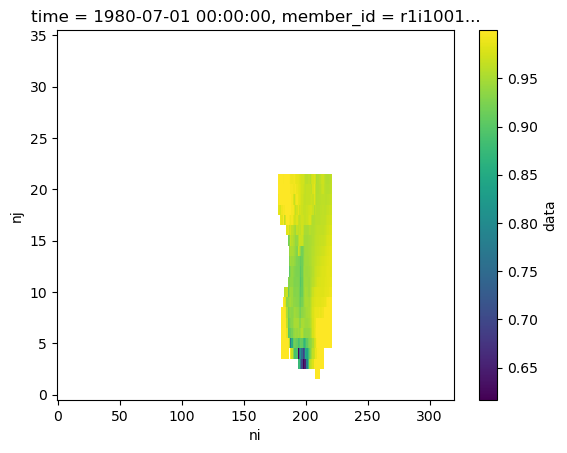

In [30]:
data.isel(training_times=0).plot()

In [31]:
# explicitly load data so that it doesn't take forever later on during mean
data = data.load()

### Calculate decadal node averages

In [32]:
nodes

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [33]:
# make arrays of the years by decade
yy_1980s = list(range(1980,1990,1))
yy_1990s = list(range(1990,2000,1))
yy_2000s = list(range(2000,2010,1))
yy_2010s = list(range(2010,2020,1))
yy_2020s = list(range(2020,2030,1))
yy_2030s = list(range(2030,2040,1))
yy_2040s = list(range(2040,2050,1))
yy_2050s = list(range(2050,2060,1))
yy_2060s = list(range(2060,2070,1))
yy_2070s = list(range(2070,2080,1))

In [34]:
# make numpy arrays to fill with frequencies
node_all = np.zeros([len(nodes),len(ds.nj),len(ds.ni)])
node_1980s = np.zeros([len(nodes),len(ds.nj),len(ds.ni)])
node_1990s = np.zeros([len(nodes),len(ds.nj),len(ds.ni)])
node_2000s = np.zeros([len(nodes),len(ds.nj),len(ds.ni)])
node_2010s = np.zeros([len(nodes),len(ds.nj),len(ds.ni)])
node_2020s = np.zeros([len(nodes),len(ds.nj),len(ds.ni)])
node_2030s = np.zeros([len(nodes),len(ds.nj),len(ds.ni)])
node_2040s = np.zeros([len(nodes),len(ds.nj),len(ds.ni)])
node_2050s = np.zeros([len(nodes),len(ds.nj),len(ds.ni)])
node_2060s = np.zeros([len(nodes),len(ds.nj),len(ds.ni)])
node_2070s = np.zeros([len(nodes),len(ds.nj),len(ds.ni)])

# loop through the different maps to get the indices of training data that map there
for map_num in range(len(som_keys)):
#for map_num in range(len(som_keys))[0:1]:
    # get indices of training data that mapped to this node
    inds = winmap[som_keys[map_num]]
    print(len(inds))
    # grab the compositing data that corresponds to those training times
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        ds_sub = data.isel(training_times=inds)      
    # grab data for the subset of years and average
    temp_all = ds_sub.mean(dim="training_times", skipna=True)
    temp_1980s = ds_sub.isel(training_times=ds_sub.time.dt.year.isin([yy_1980s])).mean(dim='training_times', skipna=True)
    temp_1990s = ds_sub.isel(training_times=ds_sub.time.dt.year.isin([yy_1990s])).mean(dim='training_times', skipna=True)
    temp_2000s = ds_sub.isel(training_times=ds_sub.time.dt.year.isin([yy_2000s])).mean(dim='training_times', skipna=True)
    temp_2010s = ds_sub.isel(training_times=ds_sub.time.dt.year.isin([yy_2010s])).mean(dim='training_times', skipna=True)   
    temp_2020s = ds_sub.isel(training_times=ds_sub.time.dt.year.isin([yy_2020s])).mean(dim='training_times', skipna=True)
    temp_2030s = ds_sub.isel(training_times=ds_sub.time.dt.year.isin([yy_2030s])).mean(dim='training_times', skipna=True)
    temp_2040s = ds_sub.isel(training_times=ds_sub.time.dt.year.isin([yy_2040s])).mean(dim='training_times', skipna=True)
    temp_2050s = ds_sub.isel(training_times=ds_sub.time.dt.year.isin([yy_2050s])).mean(dim='training_times', skipna=True)
    temp_2060s = ds_sub.isel(training_times=ds_sub.time.dt.year.isin([yy_2060s])).mean(dim='training_times', skipna=True)
    temp_2070s = ds_sub.isel(training_times=ds_sub.time.dt.year.isin([yy_2070s])).mean(dim='training_times', skipna=True)
    # populate the allocated arrays
    node_all[map_num,:,:] = temp_all.data
    node_1980s[map_num,:,:] = temp_1980s.data
    node_1990s[map_num,:,:] = temp_1990s.data 
    node_2000s[map_num,:,:] = temp_2000s.data
    node_2010s[map_num,:,:] = temp_2010s.data
    node_2020s[map_num,:,:] = temp_2020s.data
    node_2030s[map_num,:,:] = temp_2030s.data
    node_2040s[map_num,:,:] = temp_2040s.data
    node_2050s[map_num,:,:] = temp_2050s.data
    node_2060s[map_num,:,:] = temp_2060s.data
    node_2070s[map_num,:,:] = temp_2070s.data
    

22148
23600
11869
34819
26379
18563
36848
36003
22071


In [35]:
print(node_all.shape)

(9, 36, 320)


In [36]:
# convert the numpy array to a xarray
node_composite_all = xr.DataArray(node_all,dims=('node','nj','ni'))
node_composite_1980s = xr.DataArray(node_1980s,dims=('node','nj','ni'))
node_composite_1990s = xr.DataArray(node_1990s,dims=('node','nj','ni'))
node_composite_2000s = xr.DataArray(node_2000s,dims=('node','nj','ni'))
node_composite_2010s = xr.DataArray(node_2010s,dims=('node','nj','ni'))
node_composite_2020s = xr.DataArray(node_2020s,dims=('node','nj','ni'))
node_composite_2030s = xr.DataArray(node_2030s,dims=('node','nj','ni'))
node_composite_2040s = xr.DataArray(node_2040s,dims=('node','nj','ni'))
node_composite_2050s = xr.DataArray(node_2050s,dims=('node','nj','ni'))
node_composite_2060s = xr.DataArray(node_2060s,dims=('node','nj','ni'))
node_composite_2070s = xr.DataArray(node_2070s,dims=('node','nj','ni'))

In [37]:
# set coordinate arrays
node_composite_all['node'] = nodes
node_composite_all['ni'] = ds.ni
node_composite_all['nj'] = ds.nj

node_composite_1980s['node'] = nodes
node_composite_1980s['ni'] = ds.ni
node_composite_1980s['nj'] = ds.nj

node_composite_1990s['node'] = nodes
node_composite_1990s['ni'] = ds.ni
node_composite_1990s['nj'] = ds.nj

node_composite_2000s['node'] = nodes
node_composite_2000s['ni'] = ds.ni
node_composite_2000s['nj'] = ds.nj

node_composite_2010s['node'] = nodes
node_composite_2010s['ni'] = ds.ni
node_composite_2010s['nj'] = ds.nj

node_composite_2020s['node'] = nodes
node_composite_2020s['ni'] = ds.ni
node_composite_2020s['nj'] = ds.nj

node_composite_2030s['node'] = nodes
node_composite_2030s['ni'] = ds.ni
node_composite_2030s['nj'] = ds.nj

node_composite_2040s['node'] = nodes
node_composite_2040s['ni'] = ds.ni
node_composite_2040s['nj'] = ds.nj

node_composite_2050s['node'] = nodes
node_composite_2050s['ni'] = ds.ni
node_composite_2050s['nj'] = ds.nj

node_composite_2060s['node'] = nodes
node_composite_2060s['ni'] = ds.ni
node_composite_2060s['nj'] = ds.nj

node_composite_2070s['node'] = nodes
node_composite_2070s['ni'] = ds.ni
node_composite_2070s['nj'] = ds.nj

# Calculate differences and attribution
- 1980s with future decades (2020s, etc.)


SICdiff_future-past = sum_over_nodes[ (delta_frequency * SIC_past) + (frequency_past * delta_SIC) + (delta_frequency * delta_SIC)]
- The frequency contribution to the difference is: delta_freqency * SIC_past
- The intrapattern contribution to the difference is: frequency_past * delta_SIC
- The combination term is: delta_frequency * delta_SIC

## Calculate frequency contribution term

- delta_frequency * SIC_past

In [38]:
node_frac_dec

<xarray.DataArray (node: 9, decade: 10)>
array([[1.35782609e+01, 1.37130435e+01, 1.50043478e+01, 1.28173913e+01,
        1.35521739e+01, 9.73913043e+00, 9.15652174e+00, 4.30434783e+00,
        2.85652174e+00, 1.51304348e+00],
       [1.86869565e+01, 1.60043478e+01, 1.73826087e+01, 1.26086957e+01,
        1.44739130e+01, 9.77391304e+00, 7.55217391e+00, 3.27391304e+00,
        1.29130435e+00, 1.49130435e+00],
       [1.30521739e+01, 1.25956522e+01, 8.59130435e+00, 6.16521739e+00,
        5.04782609e+00, 3.80434783e+00, 1.67826087e+00, 2.39130435e-01,
        3.95652174e-01, 3.47826087e-02],
       [1.12217391e+01, 1.21347826e+01, 1.23739130e+01, 1.67217391e+01,
        1.52652174e+01, 1.83391304e+01, 1.77000000e+01, 1.79913043e+01,
        1.68913043e+01, 1.15130435e+01],
       [8.15652174e+00, 8.66086957e+00, 8.12608696e+00, 1.17391304e+01,
        1.13434783e+01, 1.43869565e+01, 1.43695652e+01, 1.48652174e+01,
        1.16782609e+01, 1.05391304e+01],
       [1.42173913e+01, 1.50826087e+01, 1.50739130e+01, 1.10217391e+01,
        1.15260870e+01, 6.86521739e+00, 4.26086957e+00, 1.34347826e+00,
        9.65217391e-01, 3.52173913e-01],
       [4.39565217e+00, 4.74347826e+00, 5.60434783e+00, 8.28260870e+00,
        6.50434783e+00, 1.25478261e+01, 1.62260870e+01, 2.49782609e+01,
        3.33608696e+01, 3.93521739e+01],
       [5.46086957e+00, 5.54782609e+00, 6.40000000e+00, 9.13478261e+00,
        8.73043478e+00, 1.27478261e+01, 1.88521739e+01, 2.62043478e+01,
        2.78304348e+01, 3.22043478e+01],
       [1.12304348e+01, 1.15173913e+01, 1.14434783e+01, 1.15086957e+01,
        1.35565217e+01, 1.17956522e+01, 1.02043478e+01, 6.80000000e+00,
        4.73043478e+00, 3.00000000e+00]])
Coordinates:
  * node     (node) int64 0 1 2 3 4 5 6 7 8
  * decade   (decade) <U4 '1980' '1990' '2000' '2010' ... '2050' '2060' '2070'

In [39]:
# calculate frequency differences
freq_diff_1990s = node_frac_dec.sel(decade='1990') - node_frac_dec.sel(decade='1980')
freq_diff_2000s = node_frac_dec.sel(decade='2000') - node_frac_dec.sel(decade='1980')
freq_diff_2010s = node_frac_dec.sel(decade='2010') - node_frac_dec.sel(decade='1980')
freq_diff_2020s = node_frac_dec.sel(decade='2020') - node_frac_dec.sel(decade='1980')
freq_diff_2030s = node_frac_dec.sel(decade='2030') - node_frac_dec.sel(decade='1980')
freq_diff_2040s = node_frac_dec.sel(decade='2040') - node_frac_dec.sel(decade='1980')
freq_diff_2050s = node_frac_dec.sel(decade='2050') - node_frac_dec.sel(decade='1980')
freq_diff_2060s = node_frac_dec.sel(decade='2060') - node_frac_dec.sel(decade='1980')
freq_diff_2070s = node_frac_dec.sel(decade='2070') - node_frac_dec.sel(decade='1980')

In [40]:
# calculate frequency term for each node
freq_term_1990s = freq_diff_1990s * node_composite_1980s
freq_term_2000s = freq_diff_2000s * node_composite_1980s
freq_term_2010s = freq_diff_2010s * node_composite_1980s
freq_term_2020s = freq_diff_2020s * node_composite_1980s
freq_term_2030s = freq_diff_2030s * node_composite_1980s
freq_term_2040s = freq_diff_2040s * node_composite_1980s
freq_term_2050s = freq_diff_2050s * node_composite_1980s
freq_term_2060s = freq_diff_2060s * node_composite_1980s
freq_term_2070s = freq_diff_2070s * node_composite_1980s

In [41]:
# calculate net frequency term contributions
freq_term_net_1990s = freq_term_1990s.sum(dim='node')
freq_term_net_2000s = freq_term_2000s.sum(dim='node')
freq_term_net_2010s = freq_term_2010s.sum(dim='node')
freq_term_net_2020s = freq_term_2020s.sum(dim='node')
freq_term_net_2030s = freq_term_2030s.sum(dim='node')
freq_term_net_2040s = freq_term_2040s.sum(dim='node')
freq_term_net_2050s = freq_term_2050s.sum(dim='node')
freq_term_net_2060s = freq_term_2060s.sum(dim='node')
freq_term_net_2070s = freq_term_2070s.sum(dim='node')

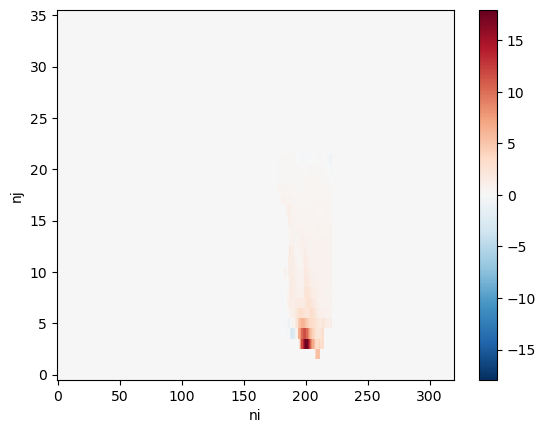

In [42]:
freq_term_net_2050s.plot()

## Calculate pattern contribution term

- frequency_past * delta_SIC

In [43]:
# calculate pattern differences
diff_1990s = node_composite_1990s - node_composite_1980s
diff_2000s = node_composite_2000s - node_composite_1980s
diff_2010s = node_composite_2010s - node_composite_1980s
diff_2020s = node_composite_2020s - node_composite_1980s
diff_2030s = node_composite_2030s - node_composite_1980s
diff_2040s = node_composite_2040s - node_composite_1980s
diff_2050s = node_composite_2050s - node_composite_1980s
diff_2060s = node_composite_2060s - node_composite_1980s
diff_2070s = node_composite_2070s - node_composite_1980s

In [44]:
freq_1980s = node_frac_dec.sel(decade='1980')

In [45]:
# calculate pattern term for each node
pattern_term_1990s = freq_1980s * diff_1990s
pattern_term_2000s = freq_1980s * diff_2000s
pattern_term_2010s = freq_1980s * diff_2010s
pattern_term_2020s = freq_1980s * diff_2020s
pattern_term_2030s = freq_1980s * diff_2030s
pattern_term_2040s = freq_1980s * diff_2040s
pattern_term_2050s = freq_1980s * diff_2050s
pattern_term_2060s = freq_1980s * diff_2060s
pattern_term_2070s = freq_1980s * diff_2070s

In [46]:
# calculate net pattern term contributions
pattern_term_net_1990s = pattern_term_1990s.sum(dim='node')
pattern_term_net_2000s = pattern_term_2000s.sum(dim='node')
pattern_term_net_2010s = pattern_term_2010s.sum(dim='node')
pattern_term_net_2020s = pattern_term_2020s.sum(dim='node')
pattern_term_net_2030s = pattern_term_2030s.sum(dim='node')
pattern_term_net_2040s = pattern_term_2040s.sum(dim='node')
pattern_term_net_2050s = pattern_term_2050s.sum(dim='node')
pattern_term_net_2060s = pattern_term_2060s.sum(dim='node')
pattern_term_net_2070s = pattern_term_2070s.sum(dim='node')

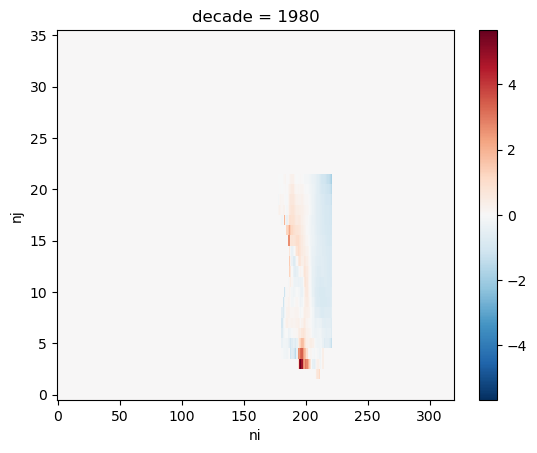

In [47]:
pattern_term_net_2050s.plot()

## Calculate combined contribution term

- delta_frequency * delta_SIC

In [48]:
# calculate combined term for each node
combined_term_1990s = freq_diff_1990s * diff_1990s
combined_term_2000s = freq_diff_2000s * diff_2000s
combined_term_2010s = freq_diff_2010s * diff_2010s
combined_term_2020s = freq_diff_2020s * diff_2020s
combined_term_2030s = freq_diff_2030s * diff_2030s
combined_term_2040s = freq_diff_2040s * diff_2040s
combined_term_2050s = freq_diff_2050s * diff_2050s
combined_term_2060s = freq_diff_2060s * diff_2060s
combined_term_2070s = freq_diff_2070s * diff_2070s

In [49]:
# calculate net combined term contributions
combined_term_net_1990s = combined_term_2020s.sum(dim='node')
combined_term_net_2000s = combined_term_2000s.sum(dim='node')
combined_term_net_2010s = combined_term_2010s.sum(dim='node')
combined_term_net_2020s = combined_term_2020s.sum(dim='node')
combined_term_net_2030s = combined_term_2030s.sum(dim='node')
combined_term_net_2040s = combined_term_2040s.sum(dim='node')
combined_term_net_2050s = combined_term_2050s.sum(dim='node')
combined_term_net_2060s = combined_term_2060s.sum(dim='node')
combined_term_net_2070s = combined_term_2070s.sum(dim='node')

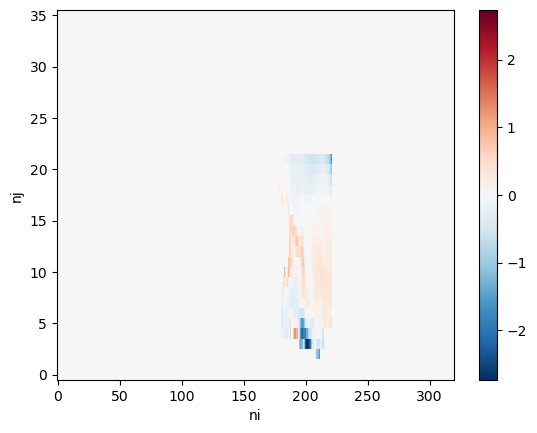

In [50]:
combined_term_net_2050s.plot()

## Calculate net diference term

- frequency term + pattern term + combined term

In [51]:
# try adding up net terms
diff_net_1990s = freq_term_net_1990s + pattern_term_net_1990s + combined_term_net_1990s
diff_net_2000s = freq_term_net_2000s + pattern_term_net_2000s + combined_term_net_2000s
diff_net_2010s = freq_term_net_2010s + pattern_term_net_2010s + combined_term_net_2010s
diff_net_2020s = freq_term_net_2020s + pattern_term_net_2020s + combined_term_net_2020s
diff_net_2030s = freq_term_net_2030s + pattern_term_net_2030s + combined_term_net_2030s
diff_net_2040s = freq_term_net_2040s + pattern_term_net_2040s + combined_term_net_2040s
diff_net_2050s = freq_term_net_2050s + pattern_term_net_2050s + combined_term_net_2050s
diff_net_2060s = freq_term_net_2060s + pattern_term_net_2060s + combined_term_net_2060s
diff_net_2070s = freq_term_net_2070s + pattern_term_net_2070s + combined_term_net_2070s

In [52]:
# try adding up net terms - just to test
diff_net_by_node_2050s = freq_term_2050s + pattern_term_2050s + combined_term_2050s

# now sum the nodes
diff_net_by_node_2050s = diff_net_by_node_2050s.sum(dim='node')

# get difference
diff_test = diff_net_2050s - diff_net_by_node_2050s

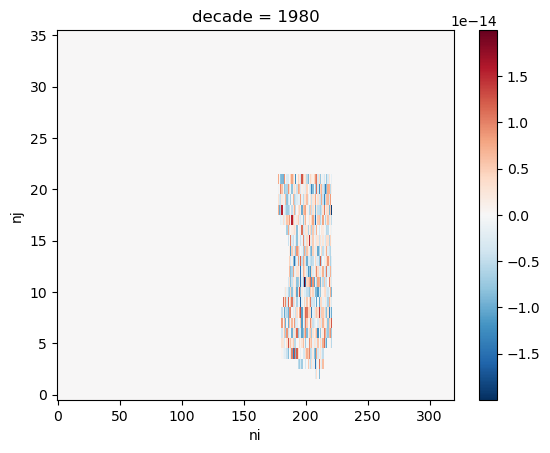

In [53]:
#diff_net_2050s.plot()
#diff_net_by_node_2050s.plot()
diff_test.plot()

## Mask by land

### Make mask that will properly color the land points

In [54]:
# file name for training variable only here 
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'
fin_mask = 'antarctic_data_for_som_composites_aice_d'
ds_mask = xr.open_mfdataset(data_path_in+fin_mask+'.nc')

In [55]:
mask = ds_mask["data"].isel(training_times=0)
mask.load()

<xarray.DataArray 'data' (nj: 36, ni: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.9999942 , 0.9999906 , 0.99997586, ...,        nan,        nan,
               nan],
       ...,
       [0.89653015, 0.89080995, 0.8772375 , ..., 0.8732328 , 0.88580495,
        0.8947713 ],
       [0.610462  , 0.5715022 , 0.4983742 , ..., 0.5884182 , 0.59032935,
        0.609117  ],
       [0.16595681, 0.13268058, 0.09189054, ..., 0.18806624, 0.17819193,
        0.17767288]], dtype=float32)
Coordinates:
    time       object 1980-07-01 00:00:00
    member_id  <U11 'r1i1001p1f1'
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT       (nj, ni) float32 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
  * nj         (nj) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * ni         (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

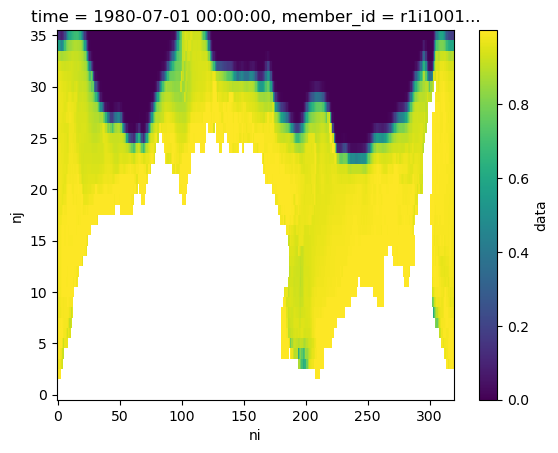

In [56]:
mask.plot()

In [57]:
# turn it into a binary mask (0 and 1)
mask = mask.where(mask>0.0,0)
mask = mask.where(mask==0, 1)

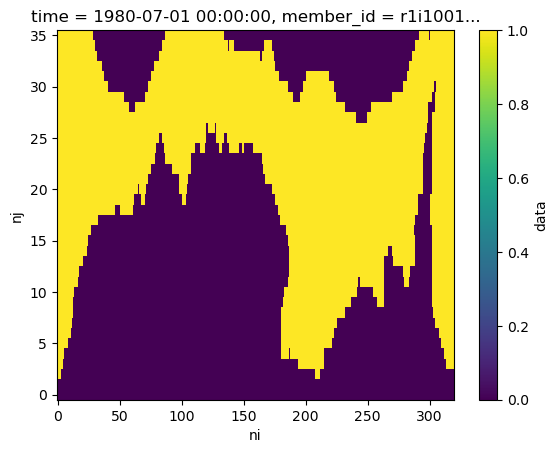

In [58]:
mask.plot()

In [59]:
mask = mask.where(mask > 0)

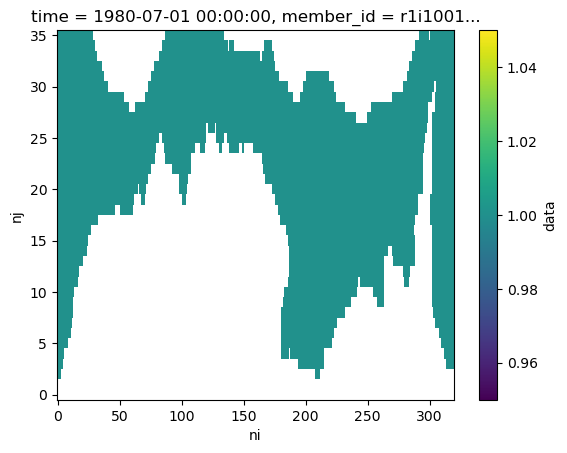

In [60]:
mask.plot()

### Mask the important data

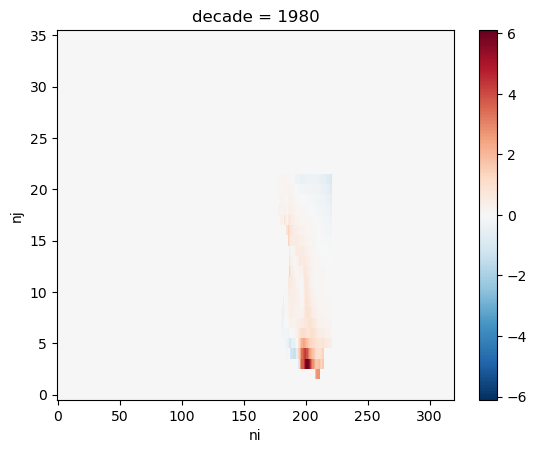

In [61]:
diff_net_2020s.plot()

In [62]:
# mask terms
diff_net_1990s = diff_net_1990s*mask
freq_term_net_1990s = freq_term_net_1990s*mask
pattern_term_net_1990s = pattern_term_net_1990s*mask
combined_term_net_1990s = combined_term_net_1990s*mask

diff_net_2000s = diff_net_2000s*mask
freq_term_net_2000s = freq_term_net_2000s*mask
pattern_term_net_2000s = pattern_term_net_2000s*mask
combined_term_net_2000s = combined_term_net_2000s*mask

diff_net_2010s = diff_net_2010s*mask
freq_term_net_2010s = freq_term_net_2010s*mask
pattern_term_net_2010s = pattern_term_net_2010s*mask
combined_term_net_2010s = combined_term_net_2010s*mask

diff_net_2020s = diff_net_2020s*mask
freq_term_net_2020s = freq_term_net_2020s*mask
pattern_term_net_2020s = pattern_term_net_2020s*mask
combined_term_net_2020s = combined_term_net_2020s*mask

diff_net_2030s = diff_net_2030s*mask
freq_term_net_2030s = freq_term_net_2030s*mask
pattern_term_net_2030s = pattern_term_net_2030s*mask
combined_term_net_2030s = combined_term_net_2030s*mask

diff_net_2040s = diff_net_2040s*mask
freq_term_net_2040s = freq_term_net_2040s*mask
pattern_term_net_2040s = pattern_term_net_2040s*mask
combined_term_net_2040s = combined_term_net_2040s*mask

diff_net_2050s = diff_net_2050s*mask
freq_term_net_2050s = freq_term_net_2050s*mask
pattern_term_net_2050s = pattern_term_net_2050s*mask
combined_term_net_2050s = combined_term_net_2050s*mask

diff_net_2060s = diff_net_2060s*mask
freq_term_net_2060s = freq_term_net_2060s*mask
pattern_term_net_2060s = pattern_term_net_2060s*mask
combined_term_net_2060s = combined_term_net_2060s*mask

diff_net_2070s = diff_net_2070s*mask
freq_term_net_2070s = freq_term_net_2070s*mask
pattern_term_net_2070s = pattern_term_net_2070s*mask
combined_term_net_2070s = combined_term_net_2070s*mask

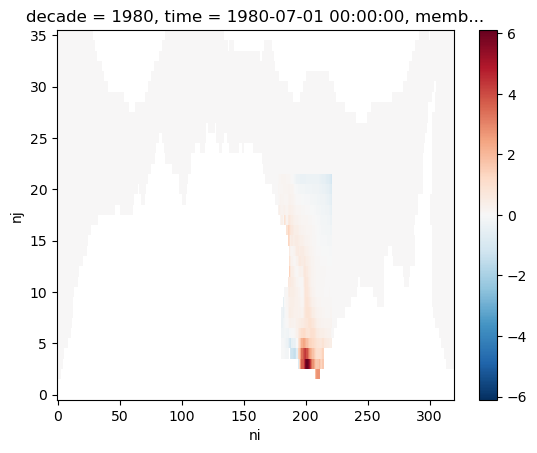

In [63]:
diff_net_2020s.plot()

## Plot the differences and term contribution for both decades

In [64]:
# set some labeling things
units = '(%)'

vmin_diff = -20
vmax_diff = 20
levels_diff = np.arange(-25,27.5,2.5)
ticks_diff = [-20,-15,-10,-5,0,5,10,15,20]
cmap_diff = cmocean.cm.diff
cmap_diff = cmap_diff.reversed()

# set missing value color
grey_tone = 0.5

In [65]:
# get lats/lons for masking
lons = ds.TLON
lats = ds.TLAT

In [66]:
shdf = gpd.read_file(fname)
# This line is important. Here we convert the projection from the shapefile one to the cartopy one 
shdf = shdf.to_crs(ccrs.SouthPolarStereo())

# Shapefile projection conversion
shdf = gpd.read_file(fname)
shdf = shdf.to_crs(ccrs.SouthPolarStereo(central_longitude=lon_avg))

### Make plots - 2070's

In [67]:
# set data for both the % calculation and the plots
tag = '2070s'
data1 = diff_net_2070s
data2 = freq_term_net_2070s
data3 = pattern_term_net_2070s
data4 = combined_term_net_2070s

In [68]:
# calculate percent contribution of each term to net difference
print('Percent differences for '+tag)
# mask to just Ross Sea area where differences are relevant
temp1 = data1.where((lats<lat_max)&(lats>lat_min) & (lons>lon_min) & (lons<lon_max) & (abs(data1)>0.5))
temp2 = data2.where((lats<lat_max)&(lats>lat_min) & (lons>lon_min) & (lons<lon_max) & (abs(data1)>0.5))
temp3 = data3.where((lats<lat_max)&(lats>lat_min) & (lons>lon_min) & (lons<lon_max) & (abs(data1)>0.5))
temp4 = data4.where((lats<lat_max)&(lats>lat_min) & (lons>lon_min) & (lons<lon_max) & (abs(data1)>0.5))

# calculate percents
answer_2 = 100*(temp2/temp1).mean(dim=['nj','ni'])
print('Frequency contribution: ')
print(answer_2.values)
answer_3 = 100*(temp3/temp1).mean(dim=['nj','ni'])
print('Pattern contribution: ')
print(answer_3.values)
answer_4 = 100*(temp4/temp1).mean(dim=['nj','ni'])
print('Combined contribution: ')
print(answer_4.values)

# verify this adds to 100%
answer_1 = answer_2+answer_3+answer_4
print('total contribution:')
print(answer_1.values)

Percent differences for 2070s
Frequency contribution: 
89.78098654572679
Pattern contribution: 
-1.6185254595214533
Combined contribution: 
11.837538913794656
total contribution:
100.0


In [72]:
fout = path_out+'fig_7_SOM_contributions'

/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


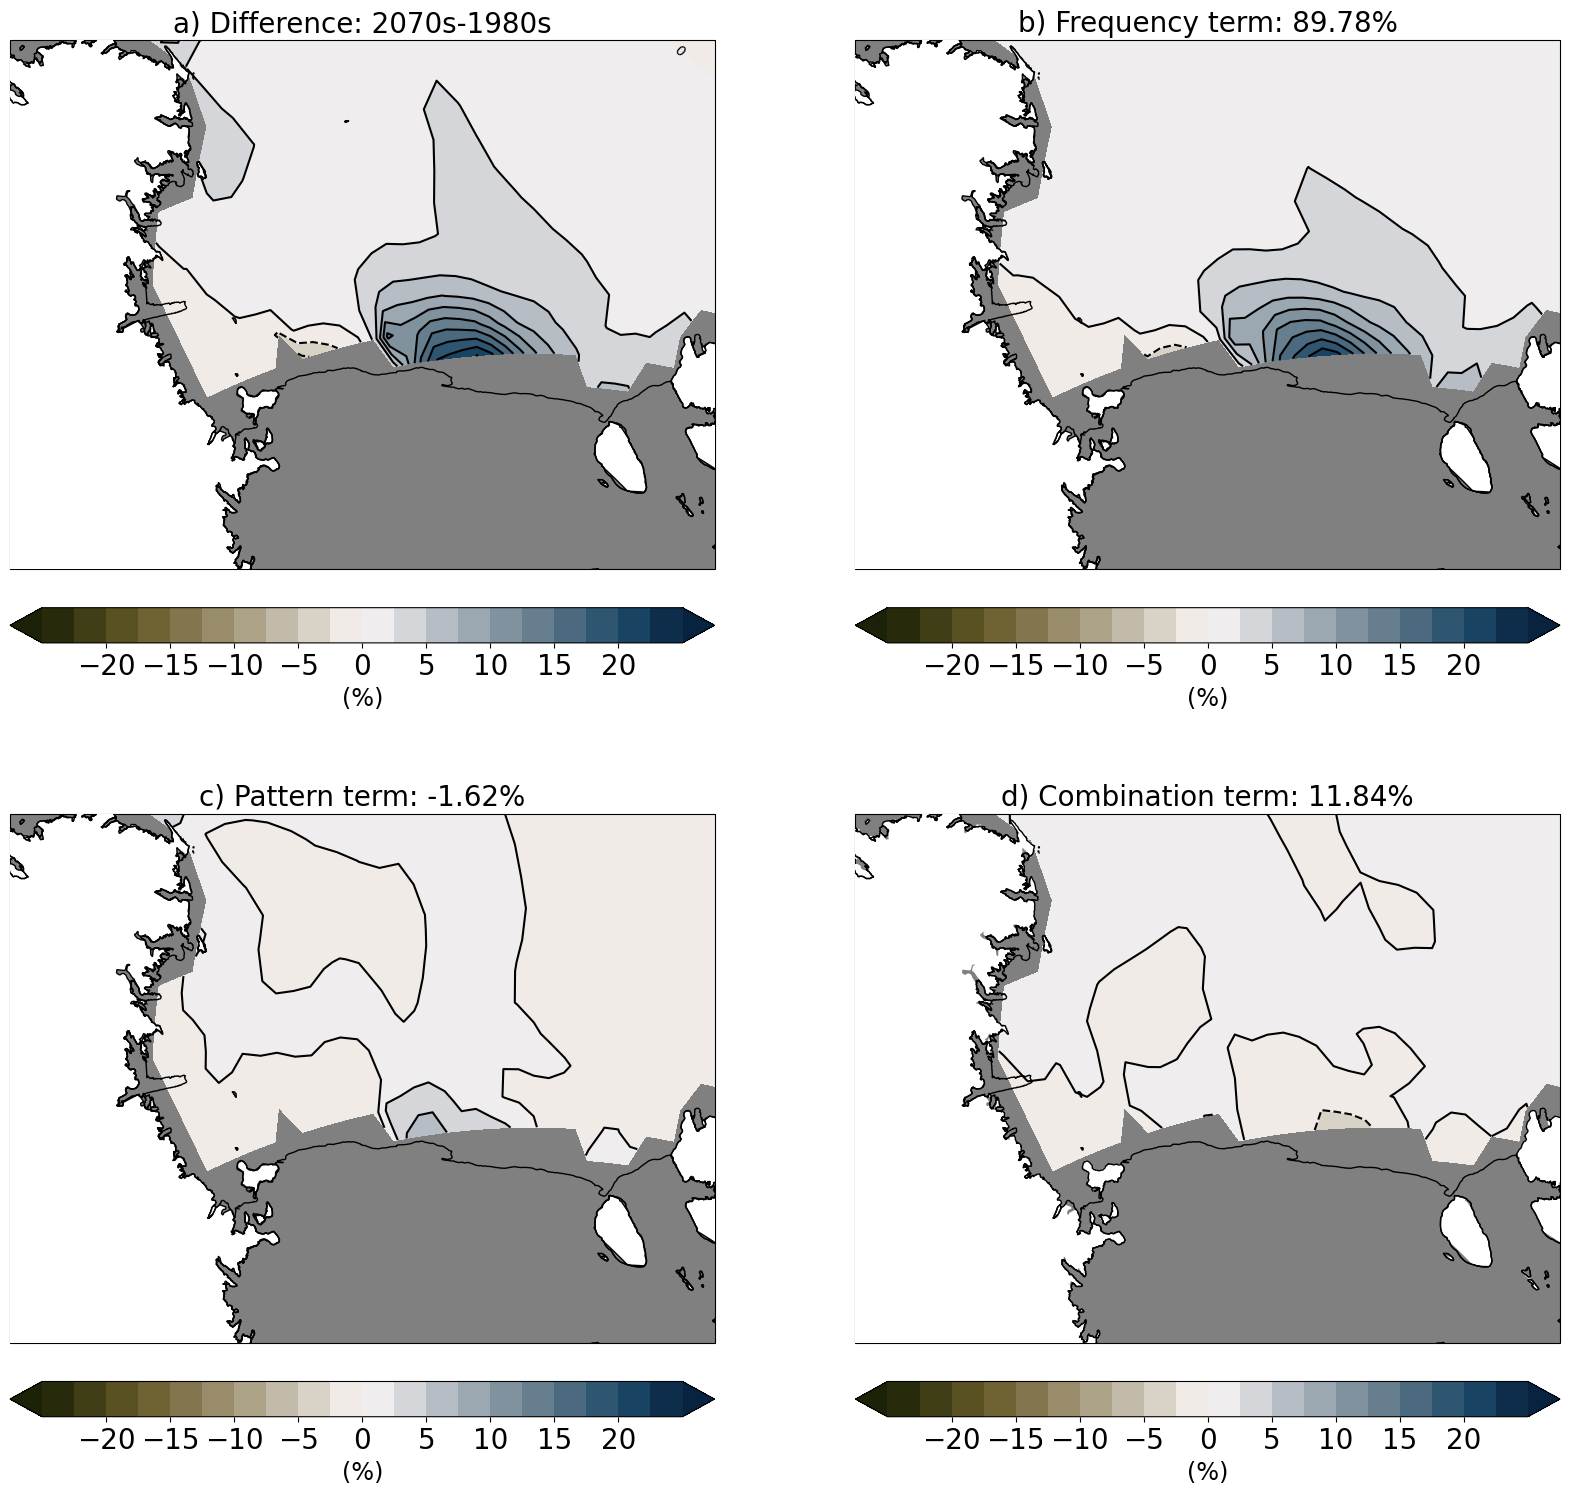

In [73]:
## Plot the 2070s difference and term contributions

# create figure
fig = plt.figure(figsize=(20,20))
title = 'Winter (JAS) Ross Sea and contributions '+tag+' - 1980s'

# plot the subplots - note it's nrow x ncol x index (starting upper left)

### net difference
ax = fig.add_subplot(2,2,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
# set face colors
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
# fix variable
lon, lat, field = utils.adjust_pop_grid(lons, lats, data1)
this = ax.contourf(lon,lat,
                     field,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,fraction=0.15,pad=0.05)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(units, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lon,lat,
                   field,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_diff,extend='both',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=ticks_diff)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
#ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('a) Difference: '+tag+'-1980s',fontsize=20)

### frequency term
ax = fig.add_subplot(2,2,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
# set face colors
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
# fix variable
lon, lat, field = utils.adjust_pop_grid(lons, lats, data2)
this = ax.contourf(lon,lat,
                     field,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,fraction=0.15,pad=0.05)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(units, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lon,lat,
                   field,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_diff,extend='both',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=ticks_diff)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
#ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('b) Frequency term: '+"{:.2f}".format(answer_2.values)+'%',fontsize=20)

### pattern term
ax = fig.add_subplot(2,2,3, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
# set face colors
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
# fix variable
lon, lat, field = utils.adjust_pop_grid(lons, lats, data3)
this = ax.contourf(lon,lat,
                     field,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,fraction=0.15,pad=0.05)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(units, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lon,lat,
                   field,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_diff,extend='both',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=ticks_diff)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
#ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('c) Pattern term: '+"{:.2f}".format(answer_3.values)+'%',fontsize=20)

### Combined term
ax = fig.add_subplot(2,2,4, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
# set face colors
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
# fix variable
lon, lat, field = utils.adjust_pop_grid(lons, lats, data4)
this = ax.contourf(lon,lat,
                     field,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,fraction=0.15,pad=0.05)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(units, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lon,lat,
                   field,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_diff,extend='both',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=ticks_diff)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='none', facecolor='w')    
#ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('d) Combination term: '+"{:.2f}".format(answer_4.values)+'%',fontsize=20)

# Finalize figure and save
#fig.suptitle(title,fontsize=15, y=0.8)
fig.subplots_adjust(hspace=0.01)

fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)